<a href="https://colab.research.google.com/github/lastinm/ml_hw_notebooks/blob/main/%D0%91%D0%B8%D0%B7%D0%BD%D0%B5%D1%81_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Бизнес-применение машинного обучения. Итоговый проект

Маркетинговые агенства хотят проводить успешные рекламные кампании, но рынок сложен, что требует оценивать эффективности разных вариантов, что обуславливает необходимость проведения АБ-тестирования.

Компании заинтересованы в ответах на два вопроса:

1. Будет ли кампания успешной?

2. Если кампания была успешной, насколько этот успех можно объяснить рекламой?

Большинство людей будут видеть рекламу (экспериментальная группа). А небольшая часть людей (контрольная группа) вместо этого увидит объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама.

Идея задания состоит в том, чтобы проанализировать группы, выяснить, была ли реклама успешной, сколько компания может заработать на рекламе и является ли разница между группами статистически значимой.

## ДАТАСЕТ

In [1]:
# подключение диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Чтение CSV файла напрямую из zip архива
import pandas as pd
ab_data = pd.read_csv('/content/drive/MyDrive/Data/AB-tests_HW.zip', compression='zip', header=0, sep=',')
ab_data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Словарь данных:

**user id**: Идентификатор пользователя (уникальный).

**test group**: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.

**converted**: Если человек купил продукт, то True, иначе False.

**total ads**: Количество рекламы, увиденной человеком.

**most ads day**: День, в который человек увидел наибольшее количество рекламы.

**most ads hour**: Час дня, в который человек увидел наибольшее количество рекламы.

## АНАЛИЗ ДАННЫХ

### Исследование структуры данных

In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


* Имеется 588101 запись и 7 колонок.

* Все колонки содержат ненулевые значения, что говорит о том, что нет пропусков.

* Данные в колонках имеют разные типы. Например, converted — булевый тип, что хорошо. Однако стоит обратить внимание на типы данных других колонок.

### Преобразование столбцов к необходимым типам данных

In [4]:
# Преобразование нужных колонок
ab_data['most ads day'] = ab_data['most ads day'].astype('category')
ab_data['test group'] = ab_data['test group'].astype('category')

In [5]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test group     588101 non-null  category
 3   converted      588101 non-null  bool    
 4   total ads      588101 non-null  int64   
 5   most ads day   588101 non-null  category
 6   most ads hour  588101 non-null  int64   
dtypes: bool(1), category(2), int64(4)
memory usage: 19.6 MB


In [6]:
ab_data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### Проверка данных на наличие дубликатов пользователей в обеих группах

Убедимся, что пользователи не попали в обе группы, мы можем сделать следующее:

* Используем метод группировки (groupby) для анализа user id и test group.
* Проверим, сколько уникальных пользователей (user id) прошло через каждую группу.
* Удалим пользователей, которые оказались в обеих группах.

In [7]:
# Поработаем с пользователями
duplicates = ab_data.groupby('user id')['test group'].nunique()
users_in_both_groups = duplicates[duplicates > 1].index

# Отфильтруем дубликаты
ab_data_filtered = ab_data[~ab_data['user id'].isin(users_in_both_groups)]
ab_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test group     588101 non-null  category
 3   converted      588101 non-null  bool    
 4   total ads      588101 non-null  int64   
 5   most ads day   588101 non-null  category
 6   most ads hour  588101 non-null  int64   
dtypes: bool(1), category(2), int64(4)
memory usage: 19.6 MB


Пользователь состаящие в обоих группах не выявлены.

##  Первичный анализ результатов A/B-тестирования


Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

 * количество посещений сайта:


In [8]:
# Разделение на контрольную и тестовую группы
ad_group = ab_data[ab_data['test group'] == 'ad']
psa_group = ab_data[ab_data['test group'] == 'psa']

In [9]:
# Подсчет уникальных пользователей
ad_unique_users = ad_group['user id'].nunique()
psa_unique_users = psa_group['user id'].nunique()

* суммарное количество совершённых покупок:

In [10]:
# Подсчет суммарного количества совершённых покупок
ab_total_converted = ad_group['converted'].sum()
psa_total_converted = psa_group['converted'].sum()

In [11]:
# Вывод результата
print(f"Тестовая группа (ad):")
print(f"Суммарное количество совершённых покупок: {ab_total_converted}")
print(f"Количество уникальных пользователей: {ad_unique_users}")

print(f"\nКонтрольная группа (psa):")
print(f"Суммарное количество совершённых покупок: {psa_total_converted}")
print(f"Количество уникальных пользователей: {psa_unique_users}")

Тестовая группа (ad):
Суммарное количество совершённых покупок: 14423
Количество уникальных пользователей: 564577

Контрольная группа (psa):
Суммарное количество совершённых покупок: 420
Количество уникальных пользователей: 23524


*Сбалансированность выборок:*

Поскольку контрольная группа состоит из значительно меньшего числа уникальных пользователей, а также из-за значительно меньшего количества покупок, можно говорить о том, что выборки не сбалансированы. Это может создать предвзятость в результатах анализа, особенно если пользователи в этих группах отличаются по критериям, влияющим на поведение при покупке.

В каждой из групп рассчитайте ключевые показатели:

* конверсия:



Конверсия — это метрика, которая позволяет понять, какая доля пользователей выполнила целевое действие (в данном случае, совершила покупку) по отношению к общему числу уникальных пользователей в группе. Для ее расчета используется следующая формула:

Конверсия = Количество покупок / Количество уникальных пользователей * 100%

In [12]:
# Функция для расчета конверсии
def calculate_conversion(purchases, unique_users):
    if unique_users == 0:
        return 0  # Избегаем деления на ноль
    return (purchases / unique_users) * 100  # Возвращаем конверсию в процентах

# Расчет конверсии для обеих групп
conversion_ad = calculate_conversion(ab_total_converted, ad_unique_users)
conversion_psa = calculate_conversion(psa_total_converted, psa_unique_users)

# Вывод результатов
print(f"Конверсия тестовой группы (ad): {conversion_ad:.2f}%")
print(f"Конверсия контрольной группы (psa): {conversion_psa:.2f}%")

Конверсия тестовой группы (ad): 2.55%
Конверсия контрольной группы (psa): 1.79%


* среднее количество рекламы, увиденной пользователем:

Используем следующую формулу для расчета среднего количества рекламы, увиденной пользователем:

Среднее количество рекламы на пользователя = Общее количество показов рекламы / Количество уникальных пользователей

In [13]:
# Подсчет количества показанной рекламы
ad_total_ads = ad_group['total ads'].sum()
psa_total_ads = psa_group['total ads'].sum()

In [14]:
# Расчет среднего количества рекламы на пользователя для обеих групп
average_impressions_ad = ad_total_ads / ad_unique_users
average_impressions_psa = psa_total_ads / psa_unique_users

# Вывод результатов
print(f"Среднее количество рекламы на пользователя (ad): {average_impressions_ad:.2f}")
print(f"Среднее количество рекламы на пользователя (psa): {average_impressions_psa:.2f}")

Среднее количество рекламы на пользователя (ad): 24.82
Среднее количество рекламы на пользователя (psa): 24.76


# Cтатистический анализ результатов A/B-тестирования

С помощью аппарата статистических тестов определите:

* Есть ли статистическая разница между конверсиями в группах А и B?

 ## Z-ТЕСТ ДЛЯ ПРОПОРЦИЙ

Наша задача состоит в том, чтобы проверить гипотезу о равенстве (различии) между конверсиями в группах, исходя из выборочных данных.

Применим Z-тест для пропорций на примере двух типов показа рекламы. Возьмём в качестве альтернативной двустороннюю гипотезу о неравенстве пропорций с параметром value=0. То есть у нас будут две следующие конкурирующие гипотезы:

Нулевая (будет задавать отсутствие эффекта): конверсии в группах ab и psa равны.


Альтернативная (будет задавать наличие эффекта): конверсии в группах ab и psa не равны.

Сначала подготовим данные к проведению статистических тестов. Для проведения статистических тестов нам нужно знать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой контрольной и тестовой группах.

Cгруппируем таблицу ab_data по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы:

In [19]:
converted_piv= ab_data.groupby('test group', observed=False)['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
test group,,
ad,14423,564577
psa,420,23524


Мы знаем, что группы независимые: пользователи в группах ad и psa не пересекаются. Значит, нам нужно воспользоваться Z-критерием:

In [15]:
from statsmodels.stats.proportion import proportions_ztest

In [24]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 10))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Так как Z-тест для пропорций показал, что истинные значения конверсий в группах не равны (с уровнем значимости 0.05), для нас это значит, что альтернативная гипотеза подтверждается статистически.

Переводим на язык бизнеса: между вариантами показа есть разница.

## ХИ-квадрат-ТЕСТ ДЛЯ ПРОПОРЦИЙ

In [21]:
from statsmodels.stats.proportion import proportions_chisquare

In [22]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Мы получили то же самое значение p-value, что и при тестировании гипотез с помощью Z-теста. Это неудивительно, ведь Z-критерий основан на нормальном распределении, а Хи2-критерий основан на Хи2-распределении, которое получается как сумма квадратов случайных величин, распределённых нормально.

То есть способы вычисления статистики для Z- и Хи2-критериев отличаются математически, однако при большом количестве наблюдений p-value для этих критериев будут совпадать.

Итак, согласно критерию Хи2, у нас есть основания отвергнуть нулевую гипотезу в пользу альтернативной, а значит, мы в очередной раз подтвердили, что существует разница в показаказе рекламы для конверсии.

## ПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

* Есть ли статистическая разница между средними количествами увиденной рекламы в группах А и B?

Рассчитаем среднее и медианное количество рекламы в каждой группе:

In [27]:
# Группируем данные по тестовой группе и рассчитываем среднее и медиану времени
grouped = ab_data.groupby('test group', observed=False)['total ads'].agg(['mean', 'median'])

# Печатаем результат
grouped

,mean,median
test group,,
ad,24.823365,13.0
psa,24.761138,12.0


По предварительным подсчётам, среднее количество увиденной рекламы, в группе ad выше, чем в группе psa. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

Чтобы определить, существует ли статистически значимая разница в средних количествах увиденной рекламы между группами "ad" и "psa", можно использовать параметрический тест, такой как t-тест для независимых выборок. Этот тест проверяет, есть ли значительная разница между средними значениями двух групп.

In [50]:
from scipy import stats
import matplotlib.pyplot as plt

# Разделяем данные по группам
ad_group = ab_data[ab_data['test group'] == 'ad']['total ads']
psa_group = ab_data[ab_data['test group'] == 'psa']['total ads']

Посмотрим на распределение визуально:

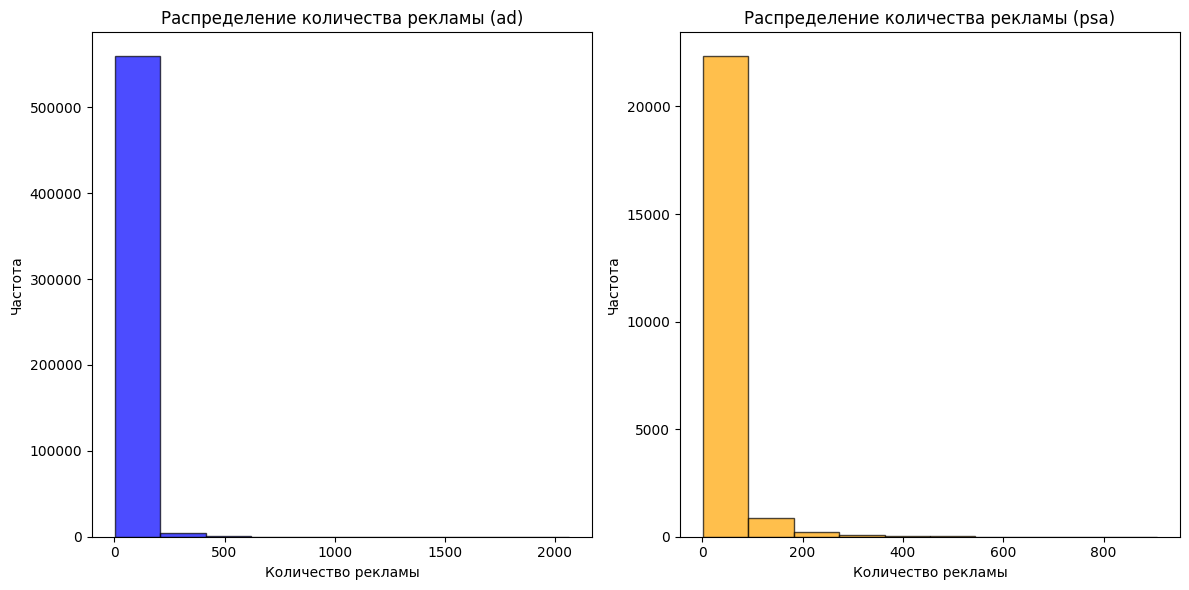

In [51]:
import matplotlib.pyplot as plt

# Настройка графика
plt.figure(figsize=(12, 6))

# Гистограмма для группы "ad"
plt.subplot(1, 2, 1)
plt.hist(ad_group, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Распределение количества рекламы (ad)')
plt.xlabel('Количество рекламы')
plt.ylabel('Частота')

# Гистограмма для группы "psa"
plt.subplot(1, 2, 2)
plt.hist(psa_group, bins=10, color='orange', alpha=0.7, edgecolor='black')
plt.title('Распределение количества рекламы (psa)')
plt.xlabel('Количество рекламы')
plt.ylabel('Частота')

# Показать график
plt.tight_layout()
plt.show()

Данные не распределены нормально. Проверим, на всякий случай, распределение тестом Шапиро-Уилка:

In [52]:
# Шаг 2: Проверка нормальности (по желанию)
shapiro_ad = stats.shapiro(ad_group)
shapiro_psa = stats.shapiro(psa_group)

print("Shapiro-Wilk test for 'ad' group:", shapiro_ad)
print("Shapiro-Wilk test for 'psa' group:", shapiro_psa)

Shapiro-Wilk test for 'ad' group: ShapiroResult(statistic=0.47862770192829296, pvalue=3.701044472444164e-203)
Shapiro-Wilk test for 'psa' group: ShapiroResult(statistic=0.515901874841278, pvalue=7.270789402370636e-120)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 564577.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23524.
  res = hypotest_fun_out(*samples, **kwds)


Результаты теста Шапиро-Уилка: Если p-value для Shapiro-Wilk теста меньше уровня значимости (обычно 0.05), это указывает на то, что данные не распределены нормально. Тест подтвердил выводы, сделанные нами визуально по гистограммам.

Если данные нормально распределены, можно было бы провести t-тест; если нет — стоит рассмотреть вариант непараметрических тестов, например, тест Манна-Уитни.